### Absolute geolocation error (ALE) of Sentinel-1 IW SLC in CRs (Rosamond, CA)

<B><I>Input image</I></B>
  <br>
  &nbsp;&nbsp;&nbsp;&nbsp;Sentinel-1 processed by ISCE2 (Sentinel-1A IPF version 003.31)
  <br>
   &nbsp;&nbsp;&nbsp;&nbsp;relative orbit: 71
  <br>
  &nbsp;&nbsp;&nbsp;&nbsp;satellite direction: descending
  <br>
  &nbsp;&nbsp;&nbsp;&nbsp;acquisition date: 2021 01 06
  <br>
  &nbsp;&nbsp;&nbsp;&nbsp;subswath: IW2 <b>(NOTE: this notebook is only for a single subswath CSLC)</b>
  <br>
  &nbsp;&nbsp;&nbsp;&nbsp;number of bursts: 2
  <br>
  &nbsp;&nbsp;&nbsp;&nbsp;Rosamond corner reflectors locate in burst No. 2

<B><I>Accuracy requirement of the Sentinel-1 CSLC product (CSLC-S1)</I></B>
<ul>
    <li>0.75 m in range</li>
    <li>1.5 m in azimuth</li>
</ul>

<div class="alert alert-warning">
Corrections to be applied for estimating ALE<br>
<ul>    
    <li>Plate motion</li>
    <li>Solid Earth Tide (SET)</li>
    <li>Ionospheric effect in range</li>
    <li>Bistatic offsets in azimuth</li>
    <li>Doppler shift in range</li>
    <li>Topographic induced shift in azimuth due to Doppler FM-rate mismatch</li>
    <li>Tropospheric effect in range</li>
</ul>
</div>

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import os
import scipy

import pysolid
import re
import math

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

from osgeo import gdal

import isce
import isceobj
from isceobj.Orbit.Orbit import Orbit, StateVector

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


#### Preparing input parameters

In [2]:
def loadProduct(xmlname):
        '''
        Load the product using Product Manager.
        '''

        from iscesys.Component.ProductManager import ProductManager as PM

        pm = PM()
        pm.configure()

        obj = pm.loadProduct(xmlname)

        return obj

In [3]:
xmlfile = './datasets/IW2.xml'
info = loadProduct(xmlfile)  #loading xml file

nbursts = info.numberOfBursts  #number of bursts in CSLC file

In [4]:
#defining parameters related with S1 annotation xml file
xmlfile_S1 = './datasets/s1a-iw2-slc-vv-20210106t135212-20210106t135240-036018-043864-005.xml' 

import xml.etree.ElementTree as ET

xmltree = ET.parse(xmlfile_S1)
xmlroot = xmltree.getroot()      #reading xml file

In [5]:
#reading orbit info from xml
orb = Orbit()  #Orbit class

for sv in info.orbit.stateVectors.list:
    
    SV = StateVector()
    
    SV.setTime(sv.getTime())
    SV.setPosition(sv.getPosition())
    SV.setVelocity(sv.getVelocity())
    
    orb.addStateVector(SV)

In [6]:
sensingStart = info.sensingStart
sensingMid = info.sensingMid
sensingStop = info.sensingStop

print(sensingStart,sensingMid,sensingStop)

#min, max time of data
orb.minTime = sensingStart
orb.maxTime = sensingStop

nearRange = info.startingRange
midRange = info.midRange
farRange = info.farRange

print('range (m) (near, mid, far)',nearRange, midRange, farRange)

#below parameters are identical in bursts of the same subswath (reading the first burst)
wvl = info.bursts.burst1.radarWavelength  #wavelength
print('wavelength (m): ', wvl)

rangePixelSize = info.bursts.burst1.rangePixelSize
print('rangepixelsize (m): ',rangePixelSize)

prf = info.bursts.burst1.prf    #pulse repetition frequency
pri = 1/prf                     #pulse repetition interval
print('PRF (Hz): ',prf)
print('PRI (s): ',pri)

from isceobj.Constants import SPEED_OF_LIGHT
C = SPEED_OF_LIGHT    #speed of light (m/s)
freq = C / wvl    #carrier frequency (Hz)
deg2rad = np.pi/180.

2021-01-06 13:52:29.060062 2021-01-06 13:52:31.990258 2021-01-06 13:52:34.920453
range (m) (near, mid, far) 846067.2431679851 875603.7612204608 905140.2792729363
wavelength (m):  0.05546576
rangepixelsize (m):  2.329562114715323
PRF (Hz):  1451.62711219399
PRI (s):  0.0006888821458346831


In [7]:
#calculating azimuth pixel spacing given satellite geometry
azimuthTimeInterval = info.bursts.burst1.azimuthTimeInterval   #line time interval
Vs = np.linalg.norm(orb.interpolateOrbit(sensingMid,method='hermite').getVelocity())  #satellite velocity at center
Ps_vec = orb.interpolateOrbit(sensingMid,method='hermite').getPosition()
Ps = np.linalg.norm(Ps_vec)  #satellite position at center

#approximate terrain height 
terrainHeight = info.bursts.burst1.terrainHeight

#latitude, longitude, elevation at image center
llh_cen = orb.rdr2geo(sensingMid,midRange,height=terrainHeight)

from isceobj.Planet.Planet import Planet
refElp = Planet(pname='Earth'). ellipsoid
xyz_cen = refElp.llh_to_xyz(llh_cen) #xyz coordinate at image center

Re = np.linalg.norm(xyz_cen)
cosb = (Ps**2 + Re**2 - midRange**2)/(2*Ps*Re)
Vg = (Re*cosb)*Vs/Ps

print('satellite velocity (m/s)',Vs)
print('satellite velocity over the ground (m/s)',Vg)

azimuthPixelSize = float(xmlroot.find('.//azimuthPixelSpacing').text)   #reading from S1 annotation xml 
# azimuthPixelSize = Vg*azimuthTimeInterval
print('azimuthPixelSize (m): ',azimuthPixelSize)

satellite velocity (m/s) 7594.599145097766
satellite velocity over the ground (m/s) 6822.502433800593
azimuthPixelSize (m):  13.94096


#### Calculating pixel location of CRs

In [8]:
#reading info of CRs
# https://uavsar.jpl.nasa.gov/cgi-bin/calibration.pl
csvCR = '2021-01-06_1352_Rosamond-corner-reflectors.csv'

df = pd.read_csv(csvCR)
#df = pd.read_csv(csvCR,index_col=0)
#renaming header for convenience
#df.index.names = ['ID']
df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
df.rename(columns={'Side length (m)':'slen'}, inplace=True)

In [9]:
df.head()

,ID,lat,lon,hgt,azm,Tilt / Elevation angle (deg),slen
0,0,34.796969,-118.096530,660.7877,170.0,12.20,2.4384
1,1,34.799773,-118.086995,660.9908,170.0,12.40,2.4384
2,2,34.805237,-118.087388,660.7979,169.5,9.20,2.4384
3,3,34.805342,-118.081910,660.9475,176.0,13.00,2.4384
4,4,34.805415,-118.076377,661.1567,176.0,12.03,2.4384


##### <I>Solid Earth Tide (SET) correction with PySolid</I>

In [10]:
dt0 = sensingStart
dt1 = sensingStop
step_sec = 5                        # sample spacing in time domain in seconds

for idx, row in df.iterrows():
    
    llh = [row['lat'], row['lon'], row['hgt']]
    
    refElp = Planet(pname='Earth'). ellipsoid
    xyz = refElp.llh_to_xyz(llh) #xyz coordinate of CR
    
    # compute SET via pysolid
    (dt_out,
     tide_e,
     tide_n,
     tide_u) = pysolid.calc_solid_earth_tides_point(llh[0], llh[1], dt0, dt1,
                                                step_sec=step_sec,
                                                display=False,
                                                verbose=False)
    
    tide_e = np.mean(tide_e[0:2])
    tide_n = np.mean(tide_n[0:2])
    tide_u = np.mean(tide_u[0:2])
    
    #updating lat,lon,hgt after SET correction
    xyz = [xyz[0]+tide_e, xyz[1]+tide_n, xyz[2]+tide_u]
    llh = refElp.xyz_to_llh(xyz)  
    
    df.loc[idx,'lat'] = llh[0]
    df.loc[idx,'lon'] = llh[1]
    df.loc[idx,'hgt'] = llh[2]    

PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.79696903/-118.09653 degree
PYSOLID: start UTC: 2021-01-06T13:52:29.060062
PYSOLID: end   UTC: 2021-01-06T13:52:34.920453
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.79977293/-118.08699515 degree
PYSOLID: start UTC: 2021-01-06T13:52:29.060062
PYSOLID: end   UTC: 2021-01-06T13:52:34.920453
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80523729/-118.08738839 degree
PYSOLID: start UTC: 2021-01-06T13:52:29.060062
PYSOLID: end   UTC: 2021-01-06T13:52:34.920453
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80534225/-118.08190983 degree
PYSOLID: start UTC: 2021-01-06T13:52:29.060062
PYSOLID: end   UTC: 2021-01-06T13:52:34.920453
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/no

#####  Locations of CRs in CSLC image

In [11]:
#pixel location of CRs 
xloc = []      #expected location of CR in range (integer)
yloc = []      #expected location of CR in azimuth (integer)
xloc_float = []   #expected location of CR in range (float)
yloc_float = []   #expected location of CR in azimuth (float)


for lat, lon, hgt in zip(df.lat,df.lon,df.hgt):
    
    llh = [lat, lon, hgt]
    
    tguess, rng = orb.geo2rdr(llh)    #main calculation for conversion between llh and pixel location
    
    xloc.append(int(np.floor((rng-nearRange)/rangePixelSize)))
    yloc.append(int(np.floor((tguess - sensingStart).total_seconds()/azimuthTimeInterval)))
    
    xloc_float.append((rng-nearRange)/rangePixelSize)
    yloc_float.append((tguess - sensingStart).total_seconds()/azimuthTimeInterval)

    
df['xloc'] = xloc
df['yloc'] = yloc
df['xloc_float'] = xloc_float
df['yloc_float'] = yloc_float

In [12]:
df.head()

,ID,lat,lon,hgt,azm,Tilt / Elevation angle (deg),slen,xloc,yloc,xloc_float,yloc_float
0,0,34.796969,-118.096530,660.859685,170.0,12.20,2.4384,23697,2022,23697.072001,2022.323592
1,1,34.799773,-118.086995,661.062783,170.0,12.40,2.4384,23467,1989,23467.298848,1989.649225
2,2,34.805238,-118.087388,660.869870,169.5,9.20,2.4384,23507,1947,23507.171915,1947.197943
3,3,34.805342,-118.081910,661.019472,176.0,13.00,2.4384,23367,1940,23367.039560,1940.245081
4,4,34.805415,-118.076377,661.228674,176.0,12.03,2.4384,23225,1933,23225.411830,1933.480975


#### Plotting CRs on SLC image

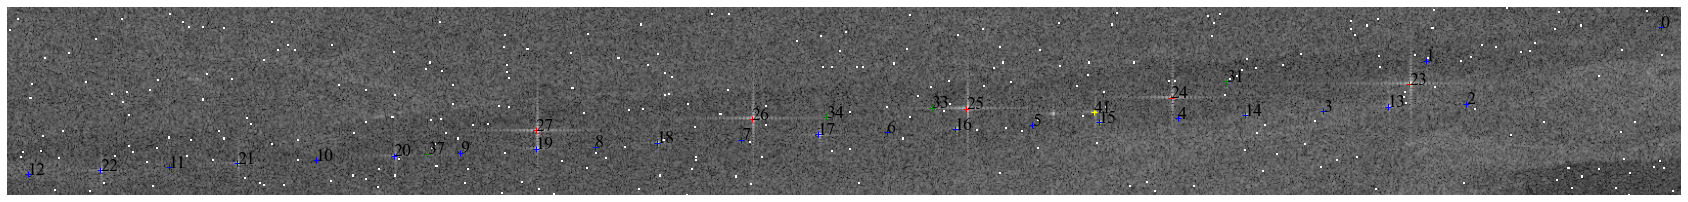

In [13]:
#reading SLC file
SLCvrt = './datasets/20210106.slc.full.vrt'

ds = gdal.Open(SLCvrt, gdal.GA_ReadOnly)
slc = ds.GetRasterBand(1).ReadAsArray()
ds = None

#extent around CRs (for figure)
buffer = 20
xmin = np.min(xloc) - buffer
xmax = np.max(xloc) + buffer
ymin = np.min(yloc) - buffer
ymax = np.max(yloc) + buffer

# put all zero values to nan and do not plot nan
try:
    slc[slc==0]=np.nan
except:
    pass

fig, ax = plt.subplots(figsize=(30, 20))
cax=ax.imshow(20*np.log10(np.abs(slc)), cmap='gray',interpolation=None, origin='upper')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.axis('off')
#cbar = fig.colorbar(cax,orientation="horizontal")
ax.set_aspect(1)

for sl in pd.unique(df.slen):
    xx = df.loc[df['slen']==sl]['xloc']
    yy = df.loc[df['slen']==sl]['yloc']
    ID = df.loc[df['slen']==sl]['ID']
    
    if sl == 2.4384:
        color='blue'
    elif sl == 4.8:
        color='red'
    elif sl == 2.8:
        color='yellow'
    else:
        color='green'
    
    ax.scatter(xx,yy,color=color,marker="+",lw=1)
    for _ID,_xx,_yy in zip(ID,xx,yy):
        ax.annotate(_ID, (_xx, _yy))

fig.savefig('Rosamond.png',dpi=300,bbox_inches='tight')

In [14]:
if info.bursts.burst1.passDirection == 'DESCENDING':
    df_filter = df.loc[df['azm']>349].reset_index(drop=True)
    #only east-looking CRs (for right-looking descending)
else:  #ASCENDING
    df_filter = df.loc[df['azm']<200].reset_index(drop=True) 
    #only west-looking CRs (for right-looking ascending)
df = None

In [15]:
df_filter

,ID,lat,lon,hgt,azm,Tilt / Elevation angle (deg),slen,xloc,yloc,xloc_float,yloc_float
0,13,34.805193,-118.084419,661.010171,350.00,9.78,2.4384,23430,1944,23430.637969,1944.227945
1,14,34.805441,-118.078914,661.020673,350.00,9.05,2.4384,23290,1936,23290.705437,1936.123569
2,15,34.805519,-118.073342,661.301675,350.75,7.35,2.4384,23148,1929,23148.092389,1929.270923
3,16,34.805549,-118.067868,661.357478,350.83,6.90,2.4384,23007,1922,23007.918897,1922.910114
4,18,34.805688,-118.056427,661.516483,350.00,9.13,2.4384,22715,1909,22715.568513,1909.003903
5,19,34.805723,-118.051816,661.482885,351.00,11.56,2.4384,22597,1903,22597.732059,1903.561581
6,20,34.805838,-118.046357,661.519587,350.00,10.61,2.4384,22458,1896,22458.722211,1896.537692
7,21,34.805901,-118.040333,661.534890,355.00,9.95,2.4384,22305,1889,22305.056716,1889.287100
8,22,34.806032,-118.035064,661.785592,354.00,10.59,2.4384,22171,1882,22171.059004,1882.354670
9,23,34.802505,-118.085804,661.289977,350.93,21.75,4.8000,23451,1966,23451.507089,1966.876801


In [16]:
#start and stop time of bursts
bursts_start_time = []
bursts_stop_time = []

for ii in range(nbursts):
    burst_ind = ii + 1
    burstname = 'info.bursts.burst' + str(burst_ind)
    
    _ = eval(burstname+'.burstStartUTC')
    bursts_start_time.append(_)
    
    _ = eval(burstname+'.burstStopUTC')
    bursts_stop_time.append(_)

In [17]:
#determining where the CRs locate among multiple bursts
loc_bursts = []   #location of CRs in multiple bursts

for idx, row in df_filter.iterrows():
    
    _aztime =sensingStart + dt.timedelta(seconds=azimuthTimeInterval * row['yloc_float'])     #azimuth time at CR
    
    for ii in range(nbursts):
        if (_aztime > bursts_start_time[ii]) and (_aztime < bursts_stop_time[ii]):
            loc_bursts.append(int(ii+1))

print('location of CRs in bursts: ',loc_bursts)
df_filter['burst_NO'] = loc_bursts

location of CRs in bursts:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [18]:
#determining where the CRs locate among multiple bursts in S1 annotation xml file
nburst_SAFE = len(xmltree.findall('.//burst'))
print("number of bursts in Sentinel-1 annotation xml file")

allburst_aztime = xmlroot.findall('.//burst/azimuthTime')
dateformat = '%Y-%m-%dT%H:%M:%S.%f'

loc_bursts_SAFE = []   #location of CRs in multiple bursts

for idx, row in df_filter.iterrows():
    
    _aztime =sensingStart + dt.timedelta(seconds=azimuthTimeInterval * row['yloc_float'])     #azimuth time at CR
    cnt = 0
    
    for ii in range(nburst_SAFE):
        _burst_aztime = dt.datetime.strptime(allburst_aztime[ii].text,dateformat)
        
        if (_aztime > _burst_aztime):
            cnt +=1
    
    loc_bursts_SAFE.append(cnt)

print('location of CRs in bursts of S1 xml file: ',loc_bursts_SAFE)
df_filter['burst_NO_SAFE'] = loc_bursts_SAFE

number of bursts in Sentinel-1 annotation xml file
location of CRs in bursts of S1 xml file:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


#### Finding CRs (intensity peak) from image

In [19]:
def slc_ovs(slc,ovsFactor=1,y=None,x=None):
    '''
    oversampling SLC data
        ovsFactor: oversampling factor
    '''
    
    if y is None:
        y = np.arange(slc.shape[0])
    if x is None:
        x = np.arange(slc.shape[1])

    rows, cols = np.shape(slc)
    _slc = np.fft.fftshift(np.fft.fft2(slc))
    min_row = math.ceil(rows * ovsFactor / 2 - rows / 2)
    max_row = min_row + rows
    min_col = math.ceil(cols * ovsFactor / 2 - cols / 2)
    max_col = min_col + cols
    
    slc_padding = np.zeros((rows * ovsFactor, cols * ovsFactor), dtype=_slc.dtype)    #zero padding
    slc_padding[min_row:max_row,min_col:max_col] = _slc
    slc_ = np.fft.fftshift(slc_padding)
    slcovs = np.fft.ifft2(slc_) * ovsFactor * ovsFactor

    y_orign_step = y[1]-y[0]
    y_ovs_step = y_orign_step/ovsFactor
    x_orign_step = x[1]-x[0]
    x_ovs_step = x_orign_step/ovsFactor

    y = np.arange(y[0],y[-1]+y_orign_step,y_ovs_step)
    x = np.arange(x[0],x[-1]+x_orign_step,x_ovs_step)

    return slcovs,y,x

In [20]:
def findCR(data,y,x,x_bound=[-np.inf,np.inf],y_bound=[-np.inf,np.inf],method="sinc"):
    '''
    Find the location of CR with fitting
    '''
    max_ind = np.argmax(data)
    max_data = data[max_ind]
    
    def _sinc2D(x,x0,y0,a,b,c):
        return c*np.sinc(a*(x[0]-x0))*np.sinc(b*(x[1]-y0))
    
    def _para2D(x,x0,y0,a,b,c,d):
        return a*(x[0]-x0)**2+b*(x[1]-y0)**2+c*(x[0]-x0)*(x[1]-y0)+d

    if method == "sinc":
        # using sinc function for fitting 
        xdata = np.vstack((x,y))
        p0 = [x[max_ind],y[max_ind],0.7,0.7,max_data]
        bounds = ([x_bound[0],y_bound[0],0,0,0],[x_bound[1],y_bound[1],1,1,np.inf])
        popt = scipy.optimize.curve_fit(_sinc2D,xdata,data,p0=p0,bounds=bounds)[0]
        x_loc = popt[0]; y_loc = popt[1]
    elif method == "para":
        #using paraboloid function for fitting
        xdata = np.vstack((x,y))
        p0 = [x[max_ind],y[max_ind],-1,-1,1,1]
        bounds = ([x_bound[0],y_bound[0],-np.inf,-np.inf,-np.inf,0],[x_bound[1],y_bound[1],0,0,np.inf,np.inf])
        popt = scipy.optimize.curve_fit(_para2D,xdata,data,p0=p0,bounds=bounds)[0]
        x_loc = popt[0]; y_loc = popt[1]

    return y_loc,x_loc

In [21]:
slc[np.isnan(slc)] = 0.0

xpeak = []
ypeak = []

for ID, xoff, yoff in zip(df_filter['ID'],df_filter['xloc'],df_filter['yloc']):

    # crop a patch of 10*10 with center at the calculated CR position
    pxbuff = 5
    pybuff = 5
    slccrop = slc[(yoff-pybuff):(yoff+pybuff+1),(xoff-pxbuff):(xoff+pxbuff+1)]
    
    # find the peak amplitude in the 10*10 patch
    yind,xind = np.unravel_index(np.argmax(np.abs(slccrop), axis=None), slccrop.shape)
    
    # give a warning if the peak and the calculated postion are too far
    dyind = yind-pybuff; dxind = xind-pxbuff
    dist = math.sqrt(dyind**2+dxind**2)
    if dist > 5.0:
        warnings.warn(f'the most bright pixel and the xloc is too far for CR {ID}')
    
    # crop a patch of 32*32 but with its center at the peak
    xbuff = 16
    ybuff = 16
    ycrop = np.arange(yoff+dyind-ybuff,yoff+dyind+ybuff+1)
    xcrop = np.arange(xoff+dxind-xbuff,xoff+dxind+xbuff+1)
    slccrop = slc[ycrop,:][:,xcrop]

    # oversample this 32*32 patch by 32
    ovsFactor = 32
    slccrop_ovs,ycrop_ovs,xcrop_ovs = slc_ovs(slccrop,ovsFactor=ovsFactor,y=ycrop,x=xcrop)

    # find the peak amplitude again in a 2 x 2 patch, it correspond to 
    # (2*ovsFactor) x (2*ovsFactor) in oversampled slc
    yoff2 = int(slccrop_ovs.shape[0]/2)
    xoff2 = int(slccrop_ovs.shape[1]/2)
    slccrop2 = slccrop_ovs[yoff2-ovsFactor:yoff2+ovsFactor+1,
                           xoff2-ovsFactor:xoff2+ovsFactor+1]
    yind2,xind2 = np.unravel_index(np.argmax(abs(slccrop2), axis=None), slccrop2.shape)
    dyind2 = yind2-ovsFactor; dxind2 = xind2-ovsFactor

    # crop a patch of 3x3 oversampled patch with center at the peak
    slccrop2 = slccrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2,xoff2+dxind2-1:xoff2+dxind2+2]
    ycrop2 = ycrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2]
    xcrop2 = xcrop_ovs[xoff2+dxind2-1:xoff2+dxind2+2]
    xxcrop2,yycrop2 = np.meshgrid(xcrop2,ycrop2)
    xxcrop2_f = xxcrop2.flatten()
    yycrop2_f = yycrop2.flatten()
    slccrop2_f = slccrop2.flatten()
    
    # using sinc function for fitting to find the location of CR
    _ypeak,_xpeak = findCR(np.abs(slccrop2_f),yycrop2_f,xxcrop2_f,
                         x_bound=[xcrop2[0],xcrop2[-1]],y_bound=[ycrop2[0],ycrop2[-1]],method="para")   
    
    xpeak.append(_xpeak)
    ypeak.append(_ypeak)

df_filter['xloc_CR'] = xpeak
df_filter['yloc_CR'] = ypeak

In [22]:
df_filter

,ID,lat,lon,hgt,azm,Tilt / Elevation angle (deg),slen,xloc,yloc,xloc_float,yloc_float,burst_NO,burst_NO_SAFE,xloc_CR,yloc_CR
0,13,34.805193,-118.084419,661.010171,350.00,9.78,2.4384,23430,1944,23430.637969,1944.227945,2,8,23432.031250,1944.093750
1,14,34.805441,-118.078914,661.020673,350.00,9.05,2.4384,23290,1936,23290.705437,1936.123569,2,8,23292.056798,1935.943819
2,15,34.805519,-118.073342,661.301675,350.75,7.35,2.4384,23148,1929,23148.092389,1929.270923,2,8,23149.484530,1929.031250
3,16,34.805549,-118.067868,661.357478,350.83,6.90,2.4384,23007,1922,23007.918897,1922.910114,2,8,23009.288467,1922.738530
4,18,34.805688,-118.056427,661.516483,350.00,9.13,2.4384,22715,1909,22715.568513,1909.003903,2,8,22716.948900,1908.790625
5,19,34.805723,-118.051816,661.482885,351.00,11.56,2.4384,22597,1903,22597.732059,1903.561581,2,8,22599.119897,1903.455531
6,20,34.805838,-118.046357,661.519587,350.00,10.61,2.4384,22458,1896,22458.722211,1896.537692,2,8,22460.093548,1896.294379
7,21,34.805901,-118.040333,661.534890,355.00,9.95,2.4384,22305,1889,22305.056716,1889.287100,2,8,22306.440501,1889.028080
8,22,34.806032,-118.035064,661.785592,354.00,10.59,2.4384,22171,1882,22171.059004,1882.354670,2,8,22172.439528,1882.008183
9,23,34.802505,-118.085804,661.289977,350.93,21.75,4.8000,23451,1966,23451.507089,1966.876801,2,8,23452.882310,1966.890161


#### <I>Tropospheric correction </I>
<I><B>Note:</B> <br>
&emsp;&emsp;This step requires MintPy and PyAPS for downloading GRIB files and calculating a range delay</I>
<br>
<I>&emsp;&emsp;For ERA5, CDS API key should exist in ~/.cdsapirc</I>

In [23]:
import tropo_utils as tu    #importing util functions in tropo_utils (from MintPy)

In [24]:
#parameters to download weather model
date_list = sensingStart.strftime('%Y%m%d')
hour = f'{sensingStart.hour:02}'
model = 'ERA5'   #weather model 
grib_dir = '.'   #current folder

#coverage of re-analysis model
minlat = int(np.floor(np.min(df_filter['lat'])))
maxlat = int(np.ceil(np.max(df_filter['lat'])))
minlon = int(np.floor(np.min(df_filter['lon'])))
maxlon = int(np.ceil(np.max(df_filter['lon'])))

snwe = (minlat, maxlat, minlon, maxlon) #coverage 

grib_files = tu.get_grib_filenames(date_list, hour, model, grib_dir, snwe) #grib file name     
print('GRIB file name to be downloaded: ',grib_files)

GRIB file name to be downloaded:  ['./ERA5_N34_N35_W119_W118_20210106_13.grb']


In [25]:
#downloading ERA5 GRIB file
tu.dload_grib_files(grib_files, tropo_model='ERA5', snwe=snwe)


------------------------------------------------------------------------------
downloading weather model data using PyAPS ...
common file size: 26640 bytes
number of grib files existed    : 1
number of grib files to download: 0
------------------------------------------------------------------------------



['./ERA5_N34_N35_W119_W118_20210106_13.grb']

In [26]:
tropo_delay = []

for idx, row in df_filter.iterrows():
    
    lat = row['lat']; lon = row['lon']; hgt = row['hgt']
    llh = [lat, lon, hgt]    #lat, lon, hgt at CR
    
    refElp = Planet(pname='Earth'). ellipsoid
    xyz = refElp.llh_to_xyz(llh) #xyz coordinate at CR
    
    _aztime =sensingStart + dt.timedelta(seconds=azimuthTimeInterval * row['yloc_CR'])     #azimuth time at CR
    xyz_pos_sat = orb.interpolateOrbit(_aztime,method='hermite').getPosition()    #satellite position at azimuth time
    los = (np.array(xyz_pos_sat)-np.array(xyz))/np.linalg.norm(np.array(xyz_pos_sat)-np.array(xyz))   #LOS vector
    n_vec = np.array([np.cos(llh[0]*deg2rad)*np.cos(llh[1]*deg2rad), 
                  np.cos(llh[0]*deg2rad)*np.sin(llh[1]*deg2rad), np.sin(llh[0]*deg2rad)])
    
    inc_ang = np.arccos(np.dot(los, n_vec))*180./np.pi #incidence angle (unit: deg)
    
    _hgt = np.zeros((1,1)); _lat = np.zeros((1,1)); _lon = np.zeros((1,1))
    _hgt[0,0] = hgt; _lat[0,0] = lat; _lon[0,0] = lon
    
    #calculating range delay estimated from weather model
    delay = tu.get_delay(grib_files[0], tropo_model='ERA5', delay_type='comb', 
                  dem=_hgt, inc=inc_ang, lat=_lat, lon=_lon, verbose=True)
    
    tropo_delay.append(-delay[0][0])
    
df_filter['tropo'] = tropo_delay

GRIB FILE: ./ERA5_N34_N35_W119_W118_20210106_13.grb
INFO: INCIDENCE ANGLE AS A NUMBER: 41.56188119542453 DEG
INFO: AREA COVERAGE IN SNWE: (36.01, 33.61, 240.72, 243.12)
PROGRESS: READING GRIB FILE
INFO: USING PRESSURE LEVELS OF ERA-INT OR ERA-5 DATA
INFO: IMAGE DIMENSIONS: 5 LATITUDES AND 5 LONGITUDES
PROGRESS: INTERPOLATING FROM PRESSURE TO HEIGHT LEVELS
PROGRESS: COMPUTING DELAY FUNCTIONS
PROGRESS: FINE INTERPOLATION OF HEIGHT LEVELS
PROGRESS: CREATE THE BILINEAR INTERPOLATION FUNCTION
PROGRESS: MAPPING THE DELAY
[============================================================] 
GRIB FILE: ./ERA5_N34_N35_W119_W118_20210106_13.grb
INFO: INCIDENCE ANGLE AS A NUMBER: 41.53404853557103 DEG
INFO: AREA COVERAGE IN SNWE: (36.01, 33.61, 240.72, 243.12)
PROGRESS: READING GRIB FILE
INFO: USING PRESSURE LEVELS OF ERA-INT OR ERA-5 DATA
INFO: IMAGE DIMENSIONS: 5 LATITUDES AND 5 LONGITUDES
PROGRESS: INTERPOLATING FROM PRESSURE TO HEIGHT LEVELS
PROGRESS: COMPUTING DELAY FUNCTIONS
PROGRESS: FINE INTERP

PROGRESS: INTERPOLATING FROM PRESSURE TO HEIGHT LEVELS
PROGRESS: COMPUTING DELAY FUNCTIONS
PROGRESS: FINE INTERPOLATION OF HEIGHT LEVELS
PROGRESS: CREATE THE BILINEAR INTERPOLATION FUNCTION
PROGRESS: MAPPING THE DELAY
[============================================================] 
GRIB FILE: ./ERA5_N34_N35_W119_W118_20210106_13.grb
INFO: INCIDENCE ANGLE AS A NUMBER: 41.47315977238259 DEG
INFO: AREA COVERAGE IN SNWE: (36.00, 33.60, 240.73, 243.13)
PROGRESS: READING GRIB FILE
INFO: USING PRESSURE LEVELS OF ERA-INT OR ERA-5 DATA
INFO: IMAGE DIMENSIONS: 5 LATITUDES AND 5 LONGITUDES
PROGRESS: INTERPOLATING FROM PRESSURE TO HEIGHT LEVELS
PROGRESS: COMPUTING DELAY FUNCTIONS
PROGRESS: FINE INTERPOLATION OF HEIGHT LEVELS
PROGRESS: CREATE THE BILINEAR INTERPOLATION FUNCTION
PROGRESS: MAPPING THE DELAY
[============================================================] 
GRIB FILE: ./ERA5_N34_N35_W119_W118_20210106_13.grb
INFO: INCIDENCE ANGLE AS A NUMBER: 41.45269215226373 DEG
INFO: AREA COVERAGE IN S

#### <I>Ionospheric correction </I>

In [27]:
# functions for parsing ionex file
#ref: https://github.com/daniestevez/jupyter_notebooks/blob/master/IONEX.ipynb
def parse_map(tecmap, exponent = -1):
    tecmap = re.split('.*END OF TEC MAP', tecmap)[0]
    return np.stack([np.fromstring(l, sep=' ') for l in re.split('.*LAT/LON1/LON2/DLON/H\\n',tecmap)[1:]])*10**exponent
    
def get_tecmaps(filename):
    with open(filename) as f:
        ionex = f.read()
        return [parse_map(t) for t in ionex.split('START OF TEC MAP')[1:]]

def get_tec(tecmap, lat, lon):
    i = round((87.5 - lat)*(tecmap.shape[0]-1)/(2*87.5))
    j = round((180 + lon)*(tecmap.shape[1]-1)/360)
    return tecmap[i,j]

In [28]:
#functions for downloading ionex from NASA CDDIS
#NOTE: requires EARTHDATA login for download

def ionex_filename(year, day, center, zipped = True):
    return '{}g{:03d}0.{:02d}i{}'.format(center, day, year % 100, '.Z' if zipped else '')

def ionex_http_path(year, day, center):
    return 'https://cddis.nasa.gov/archive/gnss/products/ionex/{:04d}/{:03d}/{}'.format(year,day,ionex_filename(year, day, center))

In [29]:
'''
showing how to download ionex file from NASA CDDIS 
but actually not downloading because of requiring EARTHDATA credential

'''

day = dt.datetime(year=sensingStart.year, month=sensingStart.month, day=sensingStart.day)
day_of_year = int(day.strftime('%j'))
center = 'jpl'

cmd = 'wget --auth-no-challenge --user=ID --password=PASSWORD '+ ionex_http_path(sensingStart.year,day_of_year,center) 
print(cmd)
# os.system(cmd)
cmd = 'gzip -d ' + ionex_filename(sensingStart.year, day_of_year, center)
print(cmd)
# os.system(cmd)
# tecfile = ionex_filename(sensingStart.year, day_of_year, center).replace('.Z','')
# print(tecfile)

wget --auth-no-challenge --user=ID --password=PASSWORD https://cddis.nasa.gov/archive/gnss/products/ionex/2021/006/jplg0060.21i.Z
gzip -d jplg0060.21i.Z


In [30]:
## parameter setup for ionospheric correction
#JPL global ionospheric map (GIM) product 
tecfile = ionex_filename(sensingStart.year, day_of_year, center).replace('.Z','')

tecmap_array = get_tecmaps(tecfile)
tecmap_array = np.array(tecmap_array)

sensing_hour = sensingStart.hour

#daily TEC map has 2-hour interval
if (sensing_hour % 2) == 0:
    ind_hour = int(sensing_hour / 2)
else:
    ind_hour = sensing_hour // 2 + 1
    
tecmap = tecmap_array[ind_hour,:,:]

In [31]:
dIon = []         #range delay due to ionospheric effect

for idx, row in df_filter.iterrows():
    
    llh_ = [row['lat'], row['lon'], row['hgt']]
    refElp = Planet(pname='Earth'). ellipsoid
    xyz_ = refElp.llh_to_xyz(llh_) #xyz coordinate at CR
    Re = np.linalg.norm(xyz_)   #local radius
    
    _aztime =sensingStart + dt.timedelta(seconds=azimuthTimeInterval * row['yloc_CR'])     #azimuth time at CR
    xyz_pos_sat = orb.interpolateOrbit(_aztime,method='hermite').getPosition()    #satellite position at azimuth time
    los = (np.array(xyz_pos_sat)-np.array(xyz_))/np.linalg.norm(np.array(xyz_pos_sat)-np.array(xyz_))   #LOS vector
    
    #finding IPP (ionospheric piercing point; intersection of satellite-target and ionospheric sphere)
    #spherical approximation
    iono_height = 450000   #effective ionospheric height (m) 
    AA =  los[0]**2+los[1]**2+los[2]**2
    BB = xyz[0]*los[0]+xyz[1]*los[1]+xyz[2]*los[2]
    CC = xyz[0]**2+xyz[1]**2+xyz[2]**2 - (Re + iono_height)**2
    
    t = (-BB + np.sqrt(BB**2-AA*CC))/AA    #approximate solution for finding IPP
    
    #xyz coordinate of IPP based on solution
    IPP_x = xyz[0] + t*los[0]; IPP_y = xyz[1] + t*los[1]; IPP_z = xyz[2] + t*los[2]
    IPP = [IPP_x, IPP_y, IPP_z]
    llh_IPP = refElp.xyz_to_llh(IPP) #lat lon hgt coordinate at IPP
    
    n_vec = np.array([np.cos(llh_IPP[0]*deg2rad)*np.cos(llh_IPP[1]*deg2rad), 
                  np.cos(llh_IPP[0]*deg2rad)*np.sin(llh_IPP[1]*deg2rad), np.sin(llh_IPP[0]*deg2rad)])

    inc_ang = np.arccos(np.dot(los, n_vec)) #incidence angle at IPP
    elv_ang = np.pi/2 - inc_ang #elevation angle at center
            
    cosX = np.sqrt(1-(Re*np.cos(elv_ang)/(Re+iono_height))**2)
    MF = 1/cosX    #mapping funciton
    
    lat_IPP = llh_IPP[0]; lon_IPP = llh_IPP[1]; hgt_IPP = llh_IPP[2]
    
    vTEC = get_tec(tecmap,lat_IPP,lon_IPP)
    _dIon = 40.3 * (10**16) / (freq**2) * vTEC * MF   #slant range path delay
    
    dIon.append(_dIon)
    
df_filter['dIon'] = dIon

#### <I>Correcting bistatic offset effects in azimuth</I>

In [32]:
bistatic = []
rank = np.floor((nearRange*2/C)/pri)
tau0 = rank * pri

for idx, row in df_filter.iterrows():
    
    midRngTime = midRange * 2 / C   #two-way mid range time
    rngTime = (nearRange + row['xloc_CR']*rangePixelSize)*2/C

    bistatic.append((midRngTime/2 + rngTime/2 - tau0)*Vg)

#### <I>Correcting Doppler shift in range and topography induced FM-rate mismatch in azimuth</I>

In [33]:
dopShift = []
fmMismatch = []

import copy

for idx, row in df_filter.iterrows():
    
    burst_no = int(row['burst_NO'])
    burstname = 'info.bursts.burst' + str(burst_no)
    dop = eval(burstname+'.doppler._coeffs')   #doppler coefficient
    
    burst_no_safe = int(row['burst_NO_SAFE']) - 1
    
    Kr = float(xmlroot.find('.//txPulseRampRate').text)   #sweep rate from S-1 SAFE annotation xml <txPulseRampRate> (Hz/s)
    all_dop_t0 = xmlroot.findall('.//dcEstimate/t0')  
    dop_t0 = float(all_dop_t0[burst_no_safe].text)   #S-1 SAFE annotation xml <dcEstimate><t0> (s)
    
    Kst = eval(burstname+'.azimuthSteeringRate')   #azimuth steering rate   (radian/s)
    Ks = 2*Vs/C*freq*Kst   #Doppler centroid rate
    
    azFmRateCoeffs = eval(burstname+'.azimuthFMRate._coeffs')
    
    all_azFmt0 = xmlroot.findall('.//azimuthFmRate/t0')
    azFmt0 = float(all_azFmt0[burst_no_safe].text)   #S-1 SAFE annotation xml <azimuthFmRate><t0> (s)
    
    rngTime = (nearRange + row['xloc_CR']*rangePixelSize)*2/C   #range time of CR reflector
    
    fdc_geom = dop[0]+dop[1]*(rngTime-dop_t0)+dop[2]*(rngTime-dop_t0)**2
    
    azFmRate = azFmRateCoeffs[0] + azFmRateCoeffs[1]*(rngTime-azFmt0) + azFmRateCoeffs[2]*(rngTime-azFmt0)**2
    Kt = azFmRate * Ks / (azFmRate - Ks)
    
    burstMid = eval(burstname+'.burstMidUTC')
#     azTime = (sensingStart - sensingMid).total_seconds() + azimuthTimeInterval * row['yloc_CR']
#     azTime = (burstStart - burstMid).total_seconds() + azimuthTimeInterval * (row['yloc_CR']-burst1line)
#     azTime = (sensingStart - burstMid).total_seconds() + azimuthTimeInterval * (row['yloc_CR']-burst1line)
    azTime = (sensingStart - burstMid).total_seconds() + azimuthTimeInterval * (row['yloc_CR'])
    
    fdc = fdc_geom + Kt * azTime
    
    planet = Planet(pname='Earth')
    refelp = copy.copy(planet.ellipsoid)
    llh_CR = [row['lat'], row['lon'], row['hgt']]
    xyz_CR = refElp.llh_to_xyz(llh_CR) #xyz coordinate at corner reflector  
    
    _aztime =sensingStart + dt.timedelta(seconds=azimuthTimeInterval * row['yloc_CR'])     #azimuth time at CR
    xyz_pos_sat = orb.interpolateOrbit(_aztime,method='hermite').getPosition()    #satellite position at azimuth time
    xyz_vel_sat = orb.interpolateOrbit(_aztime,method='hermite').getVelocity()    #satellite velocity at azimuth time
    
    #computing acceleration
    dist = np.linalg.norm(xyz_pos_sat)
    r_spinvec = np.array([0., 0., planet.spin])
    r_tempv = np.cross(r_spinvec, xyz_pos_sat)
    inert_acc = np.array([-planet.GM*x/(dist**3) for x in xyz_pos_sat])
    r_tempa = np.cross(r_spinvec, xyz_vel_sat)
    r_tempvec = np.cross(r_spinvec, r_tempv)
    xyz_acc_sat = inert_acc - 2 * r_tempa - r_tempvec   #satellite acceleration at azimuth time
    
    xyz_CR = np.array(xyz_CR)
    xyz_pos_sat = np.array(xyz_pos_sat)
    xyz_vel_sat = np.array(xyz_vel_sat)
    xyz_acc_sat = np.array(xyz_acc_sat)
    kgeo = -2/(wvl * np.linalg.norm(xyz_pos_sat-xyz_CR))*(np.dot((xyz_pos_sat-xyz_CR),xyz_acc_sat)+np.dot(xyz_vel_sat,xyz_vel_sat))
    
    dopShift.append(fdc/Kr*C/2)
    fmMismatch.append(fdc*(-1/azFmRate+1/kgeo)*Vg)

#### Calculating and plotting final ALE in range and azimuth

In [34]:
#absloute geolocation error in range and azimuth after corrections
ALE_Rg = (df_filter['xloc_CR'] -  df_filter['xloc_float'])*rangePixelSize - df_filter['dIon'] + dopShift - df_filter['tropo']
ALE_Az = (df_filter['yloc_CR'] - df_filter['yloc_float'])*azimuthPixelSize + bistatic - fmMismatch

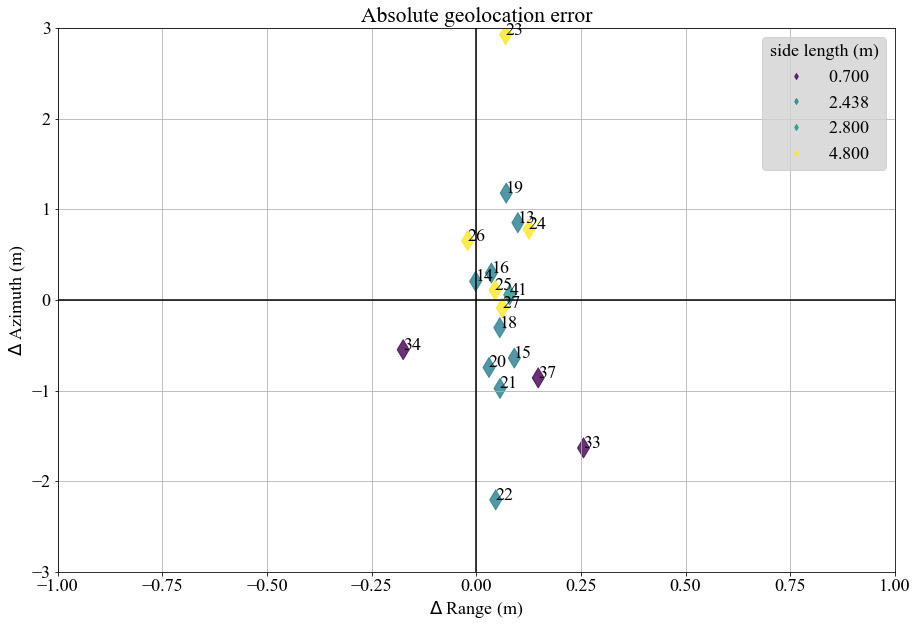

In [35]:
#plotting ALE
fig, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(ALE_Rg, ALE_Az, s=200, c=df_filter['slen'], alpha=0.8, marker='d')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.iloc[:,0]):
    ax.annotate(txt, (ALE_Rg[ii],ALE_Az[ii]))   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-1,1)
ax.set_ylim(-3,3)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title('Absolute geolocation error')
ax.set_xlabel('$\Delta$ Range (m)')
ax.set_ylabel('$\Delta$ Azimuth (m)')
fig.savefig('ALE.png',dpi=300,bbox_inches='tight')

In [36]:
print('mean ALE in range: ',np.mean(ALE_Rg), 'std ALE in range: ',np.std(ALE_Rg))
print('mean ALE in azimuth: ',np.mean(ALE_Az), 'std ALE in azimuth: ',np.std(ALE_Az))

mean ALE in range:  0.059266772600686045 std ALE in range:  0.07984202199408018
mean ALE in azimuth:  -0.2285383780465577 std ALE in azimuth:  1.3190723135695583
